In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

## Задание 12.1

In [3]:
# выгруз данных
data = pd.read_csv('../data/diy.txt')
data

ClientID  Recency  Frequency  Monetary_Q  Monetary_A
0      client13166      682          2          23        2705
1       client1239       35         43         219       42161
2      client30041      190         25         133       16057
3      client36276      289          4          12        4614
4      client14136      217          6          36       35870
...            ...      ...        ...         ...         ...
42741  client35593        1          1           3       12797
42742  client22822        1          1           4         536
42743  client23138        1          1          33        6269
42744  client32589        1          1          46       12372
42745  client25258        1          1           5         945

[42746 rows x 5 columns]

In [4]:
# выбор частоты > 1 и суммы
df = data.drop('ClientID', axis=1)[data['Frequency'] > 1][['Monetary_A', 'Frequency']]
df

Monetary_A  Frequency
0            2705          2
1           42161         43
2           16057         25
3            4614          4
4           35870          6
...           ...        ...
42656        5328          2
42660        1893          2
42677        6425          2
42687          90          2
42688        6410          2

[29887 rows x 2 columns]

In [5]:
# стандартизация

scaler = StandardScaler()
new_cols = scaler.fit_transform(df)
df_std = pd.DataFrame(new_cols, columns = df.columns)
df_std

Monetary_A  Frequency
0       -0.443535  -0.638675
1        0.597724   3.443679
2       -0.091171   1.651426
3       -0.393156  -0.439536
4        0.431702  -0.240397
...           ...        ...
29882   -0.374313  -0.638675
29883   -0.464964  -0.638675
29884   -0.345363  -0.638675
29885   -0.512546  -0.638675
29886   -0.345759  -0.638675

[29887 rows x 2 columns]

### LocalOutlierFactor

Поиск аномалий (novelty=False)

In [6]:
from sklearn.neighbors import LocalOutlierFactor

In [7]:
# обучение и предсказание
x = df_std[['Monetary_A', 'Frequency']]
clf = LocalOutlierFactor(n_neighbors=20, novelty=False)
pred = clf.fit_predict(x)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [8]:
# число аномалий в выборке
list(pred).count(-1)

75

In [9]:
# фильтрация аномалий
df_std['outlier'] = pred
df_new = df_std.loc[df_std.outlier == 1]   # датасет без аномалий
outliers = df_std.loc[df_std.outlier == -1]   # только аномалии
df_new

Monetary_A  Frequency  outlier
0       -0.443535  -0.638675        1
1        0.597724   3.443679        1
2       -0.091171   1.651426        1
3       -0.393156  -0.439536        1
4        0.431702  -0.240397        1
...           ...        ...      ...
29882   -0.374313  -0.638675        1
29883   -0.464964  -0.638675        1
29884   -0.345363  -0.638675        1
29885   -0.512546  -0.638675        1
29886   -0.345759  -0.638675        1

[29812 rows x 3 columns]

Поиск аномалий (novelty=True)

In [10]:
# обучение второй модели
x2 = df_new[['Monetary_A', 'Frequency']]

# модель по обнаружению аномалий
clf_n = LocalOutlierFactor(n_neighbors=20, novelty=True)

# обучение
clf_n.fit(x2)

# предсказание (анамалия или нет)
pred2 = clf_n.predict(outliers[['Monetary_A', 'Frequency']])
pred2

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])

Модель правильно идентиицировала все аномалии.

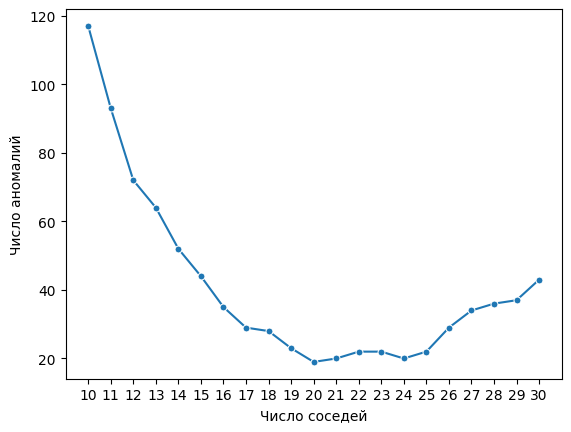

In [11]:
# поиск оптимального числа соседей
neighbors = list(range(10, 31))
c = []
for i in neighbors:
    clf = LocalOutlierFactor(n_neighbors=i, novelty=True)
    clf.fit(x2)
    pred = clf.predict(df_new[['Monetary_A', 'Frequency']])
    c.append(list(pred).count(-1))

sns.lineplot(y=c, x=neighbors, marker='o',markersize = 5)
plt.xticks(neighbors)
plt.xlabel('Число соседей')
plt.ylabel('Число аномалий')

plt.show()

Оптимальное число соседей по графику: 20

In [12]:
# поиск аномалий в датасете без аномалий
pred3 = clf_n.predict(df_new[['Monetary_A', 'Frequency']])

# число аномалий
list(pred3).count(-1)

19

Модель находит 19 аномалий там, где их не должно быть.

### IsolationForest

In [13]:
from sklearn.ensemble import IsolationForest

In [14]:
# обучение модели и предсказание
isolf = IsolationForest(contamination=75/len(x))
pred3 = isolf.fit_predict(x)
pred3

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
# число аномалий в первоначальной выборке
list(pred3).count(-1)

75

## Задание 12.2

In [17]:
data2 = pd.read_csv('../data/banks.txt', encoding='cp1251')
data2

Bank  Assents  OwnCapital  IndFunds  NBSLoans  IndLoans
0          «Авангард»   122109       20440     35443     32728      3319
1             «Аверс»   110741       24410     34918     13613      4924
2             «Агора»     1114         356       274       351       206
3    «Агропромкредит»    18774        2332     12047      6484       903
4           «Агророс»     7917        1157      3564      1909       492
..                ...      ...         ...       ...       ...       ...
366      Ю БИ ЭС Банк     7117        4164         0        43         0
367     Юг-Инвестбанк    12504        1431      7407      6637      2238
368               ЮМК     5024        2117         0      2585       235
369    Юникредит-банк  1315550      197369    267400    665780    170748
370       Яринтербанк     2820         362      1307      1732       221

[371 rows x 6 columns]

In [18]:
data2.isnull().mean()

Bank          0.0
Assents       0.0
OwnCapital    0.0
IndFunds      0.0
NBSLoans      0.0
IndLoans      0.0
dtype: float64

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# подсчёт числа выбросов
dct = {}

for i in data2.columns[1:]:
    
    q25 = data2[i].quantile(0.25)
    q75 = data2[i].quantile(0.75)
    iqr = q75-q25
    
    # количество выбросов
    c = (data2[i]>q75+1.5*iqr).sum()
    
    dct[i] = c

for key, value in dct.items():
    print(f'{key}: {value}')

Assents: 46
OwnCapital: 51
IndFunds: 61
NBSLoans: 62
IndLoans: 65


In [21]:
# удаление столбца с банками
data2 = data2.drop(columns="Bank")

# стандартизация
scaler = StandardScaler()
new_cols2 = scaler.fit_transform(data2)
df_std2 = pd.DataFrame(new_cols2, columns = data2.columns)

In [22]:
x = df_std2
clf = LocalOutlierFactor(n_neighbors=20, novelty=False)
pred = clf.fit_predict(x)

# число аномалий в выборке
list(pred).count(-1)

77

In [23]:
# фильтрация аномалий
df_std2['outlier'] = pred
df_new2 = df_std2.loc[df_std2.outlier == 1]   # датасет без аномалий
outliers = df_std2.loc[df_std2.outlier == -1]   # только аномалии
df_new2

Assents  OwnCapital  IndFunds  NBSLoans  IndLoans  outlier
0   -0.071960   -0.036578 -0.065488 -0.097648 -0.107472        1
1   -0.077810   -0.022560 -0.066141 -0.112365 -0.103954        1
2   -0.134225   -0.107495 -0.109261 -0.122575 -0.114295        1
3   -0.125137   -0.100518 -0.094608 -0.117853 -0.112768        1
4   -0.130724   -0.104667 -0.105166 -0.121375 -0.113669        1
..        ...         ...       ...       ...       ...      ...
364 -0.105893   -0.088336 -0.098665 -0.116329 -0.109951        1
365 -0.126984   -0.084716 -0.104245 -0.116114 -0.109024        1
367 -0.128363   -0.103699 -0.100383 -0.117735 -0.109841        1
368 -0.132213   -0.101277 -0.109602 -0.120855 -0.114232        1
370 -0.133347   -0.107474 -0.107975 -0.121512 -0.114263        1

[294 rows x 6 columns]

In [25]:
# Поиск аномалий
# обучение второй модели
x2 = df_new2.loc[:, df_new2.columns != 'outlier']

# модель по обнаружению аномалий
clf_n = LocalOutlierFactor(n_neighbors=20, novelty=True)

# обучение
clf_n.fit(x2)

# предсказание (анамалия или нет)
pred2 = clf_n.predict(outliers.loc[:, outliers.columns != 'outlier'])
pred2

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [26]:
# обучение модели и предсказание
isolf = IsolationForest(contamination=75/len(x))
pred = isolf.fit_predict(x)

In [27]:
list(pred).count(-1)

75